In [1]:
import Utilities.prelude
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import k3match
from scipy.optimize import fsolve
import pickle 

from src.shock_zone import shock_direction, find_prepost
from Utilities.operators import make_tree, calc_grad

# %matplotlib widget # (to go back normal %matplotlib inline)
# mpl.rcParams['figure.dpi'] = 100

In [2]:
save = True
snap = '100'
path = f'sedov/{snap}'

In [3]:
def ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, all_idx, idx, div, dir, delta, direction):
    point = np.array([x_zone[idx], y_zone[idx], z_zone[idx]])
    div_v = div[idx]
    dir_sh = np.array(dir[idx])
    
    check_zone = True # to check if the new point is in the shock zone
    while check_zone == True:
        i_tree, new_point = find_prepost(sim_tree, X, Y, Z, point, dir_sh, delta, direction)

        # find the nearest points in the grid and in the shock zone
        check_zone = are_u_shock[i_tree]

        if check_zone == True:
            # dumb way 
            idx_zone = np.argmin(np.abs(i_tree-all_idx))
            # print('check ', all_idx[idx_zone]-i_tree)
            div_next = div[idx_zone]
            dir_next = dir[idx_zone]

            # if lower div v, you discard the ray.
            if div_next < div_v:
                # print('pass')
                return False # so then you don't take this cell

            # if opposite direction in shocks, you turn/stop.
            if np.dot(dir_sh, dir_next) < 0:
                check_zone = False # so you exit from the while

        point = new_point
 
    final_tree_index = i_tree
    
    return final_tree_index

def shock_surface(sim_tree, X, Y, Z, Temp, are_u_shock, x_zone, y_zone, z_zone, all_idx, div, dir, delta):
    surface_mach = []
    surface_x = []
    surface_y = []
    surface_z = []
    post_x = []
    post_y = []
    post_z = []
    pre_x = []
    pre_y = []
    pre_z = []
    dir_x = []
    dir_y = []

    # loop over all the cells in the shock zone
    for idx in range(len(x_zone)):
        print(idx)
        post_tree_index = ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, all_idx, idx, div, dir, delta, direction = 'post')
        if post_tree_index == False:
            continue
        else:
            Tpost = Temp[post_tree_index]
            pre_tree_index = ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, all_idx, idx, div, dir, delta, direction = 'pre')
            if pre_tree_index == False:
                continue
            else:
                Tpre = Temp[pre_tree_index]

                bump = Tpost/Tpre
                # check if the bump is in the same direction of ds. CHECK THIS
                if bump < 1:
                    continue 

                surface_x.append(x_zone[idx])
                surface_y.append(y_zone[idx])
                surface_z.append(z_zone[idx])
                post_x.append(X[post_tree_index])
                post_y.append(Y[post_tree_index])
                post_z.append(Z[post_tree_index])
                pre_x.append(X[pre_tree_index])
                pre_y.append(Y[pre_tree_index])
                pre_z.append(Z[pre_tree_index])
                dir_x.append(dir[idx][0])
                dir_y.append(dir[idx][1])

                def temperature_bump(mach):
                    gamma = 5/3
                    to_solve =  ((gamma-1) * mach**2 + 2) * (2 * gamma * mach**2 - (gamma-1)) / ((gamma+1)**2 * mach**2) - bump
                    to_solve = float(to_solve)
                    return to_solve
                
                mach = fsolve(temperature_bump, 1.5)
                surface_mach.append(mach)
            
    surface_mach = np.array(surface_mach)
    surface_x = np.array(surface_x)
    surface_y = np.array(surface_y)
    surface_z = np.array(surface_z)
    post_x = np.array(post_x)
    post_y = np.array(post_y)
    post_z = np.array(post_z)
    pre_x = np.array(pre_x)
    pre_y = np.array(pre_y)
    pre_z = np.array(pre_z)
    dir_x = np.array(dir_x)
    dir_y = np.array(dir_y)

    return surface_mach, surface_x, surface_y, surface_z, post_x, post_y, post_z, pre_x, pre_y, pre_z, dir_x, dir_y


In [4]:
# Import data
shockzone = np.loadtxt(f'shockzone_{snap}.txt')
shockdir = np.loadtxt(f'shockdir_{snap}.txt')

x_zone = np.array(shockzone[0])
y_zone = shockzone[1]
z_zone = shockzone[2]
div = shockzone[3]
Tzone = shockzone[4]
idx_tree = shockzone[5]

x_dir = shockdir[0]
y_dir = shockdir[1]
z_dir = shockdir[2]
dir = []
for i in range(len(x_dir)):
    dir.append([x_dir[i], y_dir[i], z_dir[i]])

In [5]:
sim_tree, X, Y, Z, Vol, VX, VY, VZ, Den, Press, Temp = make_tree(path)
dim_cell = (3*Vol/(4*np.pi))**(1/3)

FileNotFoundError: [Errno 2] No such file or directory: 'sedov/100/CMx.npy'

In [ ]:
step = 2 * np.min(dim_cell)
z_chosen = 0

In [ ]:
step

0.036704080251267354

In [ ]:
with open(f'shockbool_{snap}.pkl', 'rb') as filebool:
    are_u_shock = pickle.load(filebool)

In [ ]:
surface_mach, surface_x, surface_y, surface_z, post_x, post_y, post_z, pre_x, pre_y, pre_z, dir_x, dir_y = shock_surface(sim_tree, X, Y, Z, Temp, are_u_shock, x_zone, y_zone, z_zone, idx_tree, div, dir, step)

0
check  0.0
1
check  0.0
2
check  0.0
3
check  0.0
4
check  0.0
5
check  0.0
6
check  0.0
check  0.0
7
check  0.0
8
check  0.0
9
check  0.0
10
check  0.0
11
check  0.0
12
check  0.0
13
check  0.0
14
check  0.0
15
check  0.0
16
check  0.0
17
check  0.0
18
check  0.0
19
check  0.0
20
check  0.0
21
check  0.0
22
check  0.0
23
check  0.0
check  0.0
24
check  0.0
25
check  0.0
26
check  0.0
27
check  0.0
28
check  0.0
29
check  0.0
30
check  0.0
31
check  0.0
32
check  0.0
33
check  0.0
34
check  0.0
35
check  0.0
36
check  0.0
37
check  0.0
38
check  0.0
39
check  0.0
40
check  0.0
41
check  0.0
42
check  0.0
43
check  0.0
44
check  0.0
45
check  0.0
46
check  0.0
47
check  0.0
48
check  0.0
49
check  0.0
50
check  0.0
51
check  0.0
52
check  0.0
check  0.0
check  0.0
check  0.0
53
check  0.0
54
check  0.0
check  0.0
check  0.0
55
check  0.0
56
check  0.0
check  0.0
check  0.0
check  0.0
57
check  0.0
58
check  0.0
59
check  0.0
check  0.0
check  0.0
check  0.0
60
check  0.0
check  0.0
ch

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_17926/1502040299.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  to_solve = float(to_solve)


check  0.0
2122
check  0.0
2123
check  0.0
2124
check  0.0
2125
check  0.0
2126
check  0.0
2127
check  0.0
2128
check  0.0
2129
check  0.0
2130
check  0.0
2131
check  0.0
2132
check  0.0
check  0.0
2133
check  0.0
2134
check  0.0
2135
check  0.0
2136
check  0.0
2137
check  0.0
2138
check  0.0
2139
check  0.0
2140
check  0.0
2141
check  0.0
2142
check  0.0
2143
check  0.0
2144
check  0.0
2145
check  0.0
check  0.0
check  0.0
check  0.0
2146
check  0.0
check  0.0
check  0.0
2147
check  0.0
check  0.0
check  0.0
check  0.0
2148
check  0.0
check  0.0
check  0.0
check  0.0
2149
check  0.0
check  0.0
check  0.0
check  0.0
2150
check  0.0
2151
check  0.0
check  0.0
check  0.0
2152
check  0.0
2153
check  0.0
2154
check  0.0
2155
check  0.0
2156
check  0.0
check  0.0
check  0.0
check  0.0
2157
check  0.0
check  0.0
check  0.0
2158
check  0.0
check  0.0
2159
check  0.0
check  0.0
2160
check  0.0
check  0.0
check  0.0
check  0.0
2161
check  0.0
check  0.0
check  0.0
2162
check  0.0
check  0.0
che

In [ ]:
if save == True:
    surface_mach_txt = np.concatenate(surface_mach)
    with open(f'shocksurface_{snap}.txt', 'w') as file:
        file.write(f'# Coordinates of the points in the shock surface \n# X \n') 
        file.write(' '.join(map(str, surface_x)) + '\n')
        file.write('# Y \n') 
        file.write(' '.join(map(str, surface_y)) + '\n')
        file.write('# Z \n') 
        file.write(' '.join(map(str, surface_z)) + '\n')
        file.write('# mach number v \n') 
        file.write(' '.join(map(str, surface_mach_txt)) + '\n')
        file.close()

In [ ]:
outlier = np.argmin(surface_mach[np.logical_and(surface_z<z_chosen+step, surface_z>z_chosen-step)])

In [ ]:
#outlier

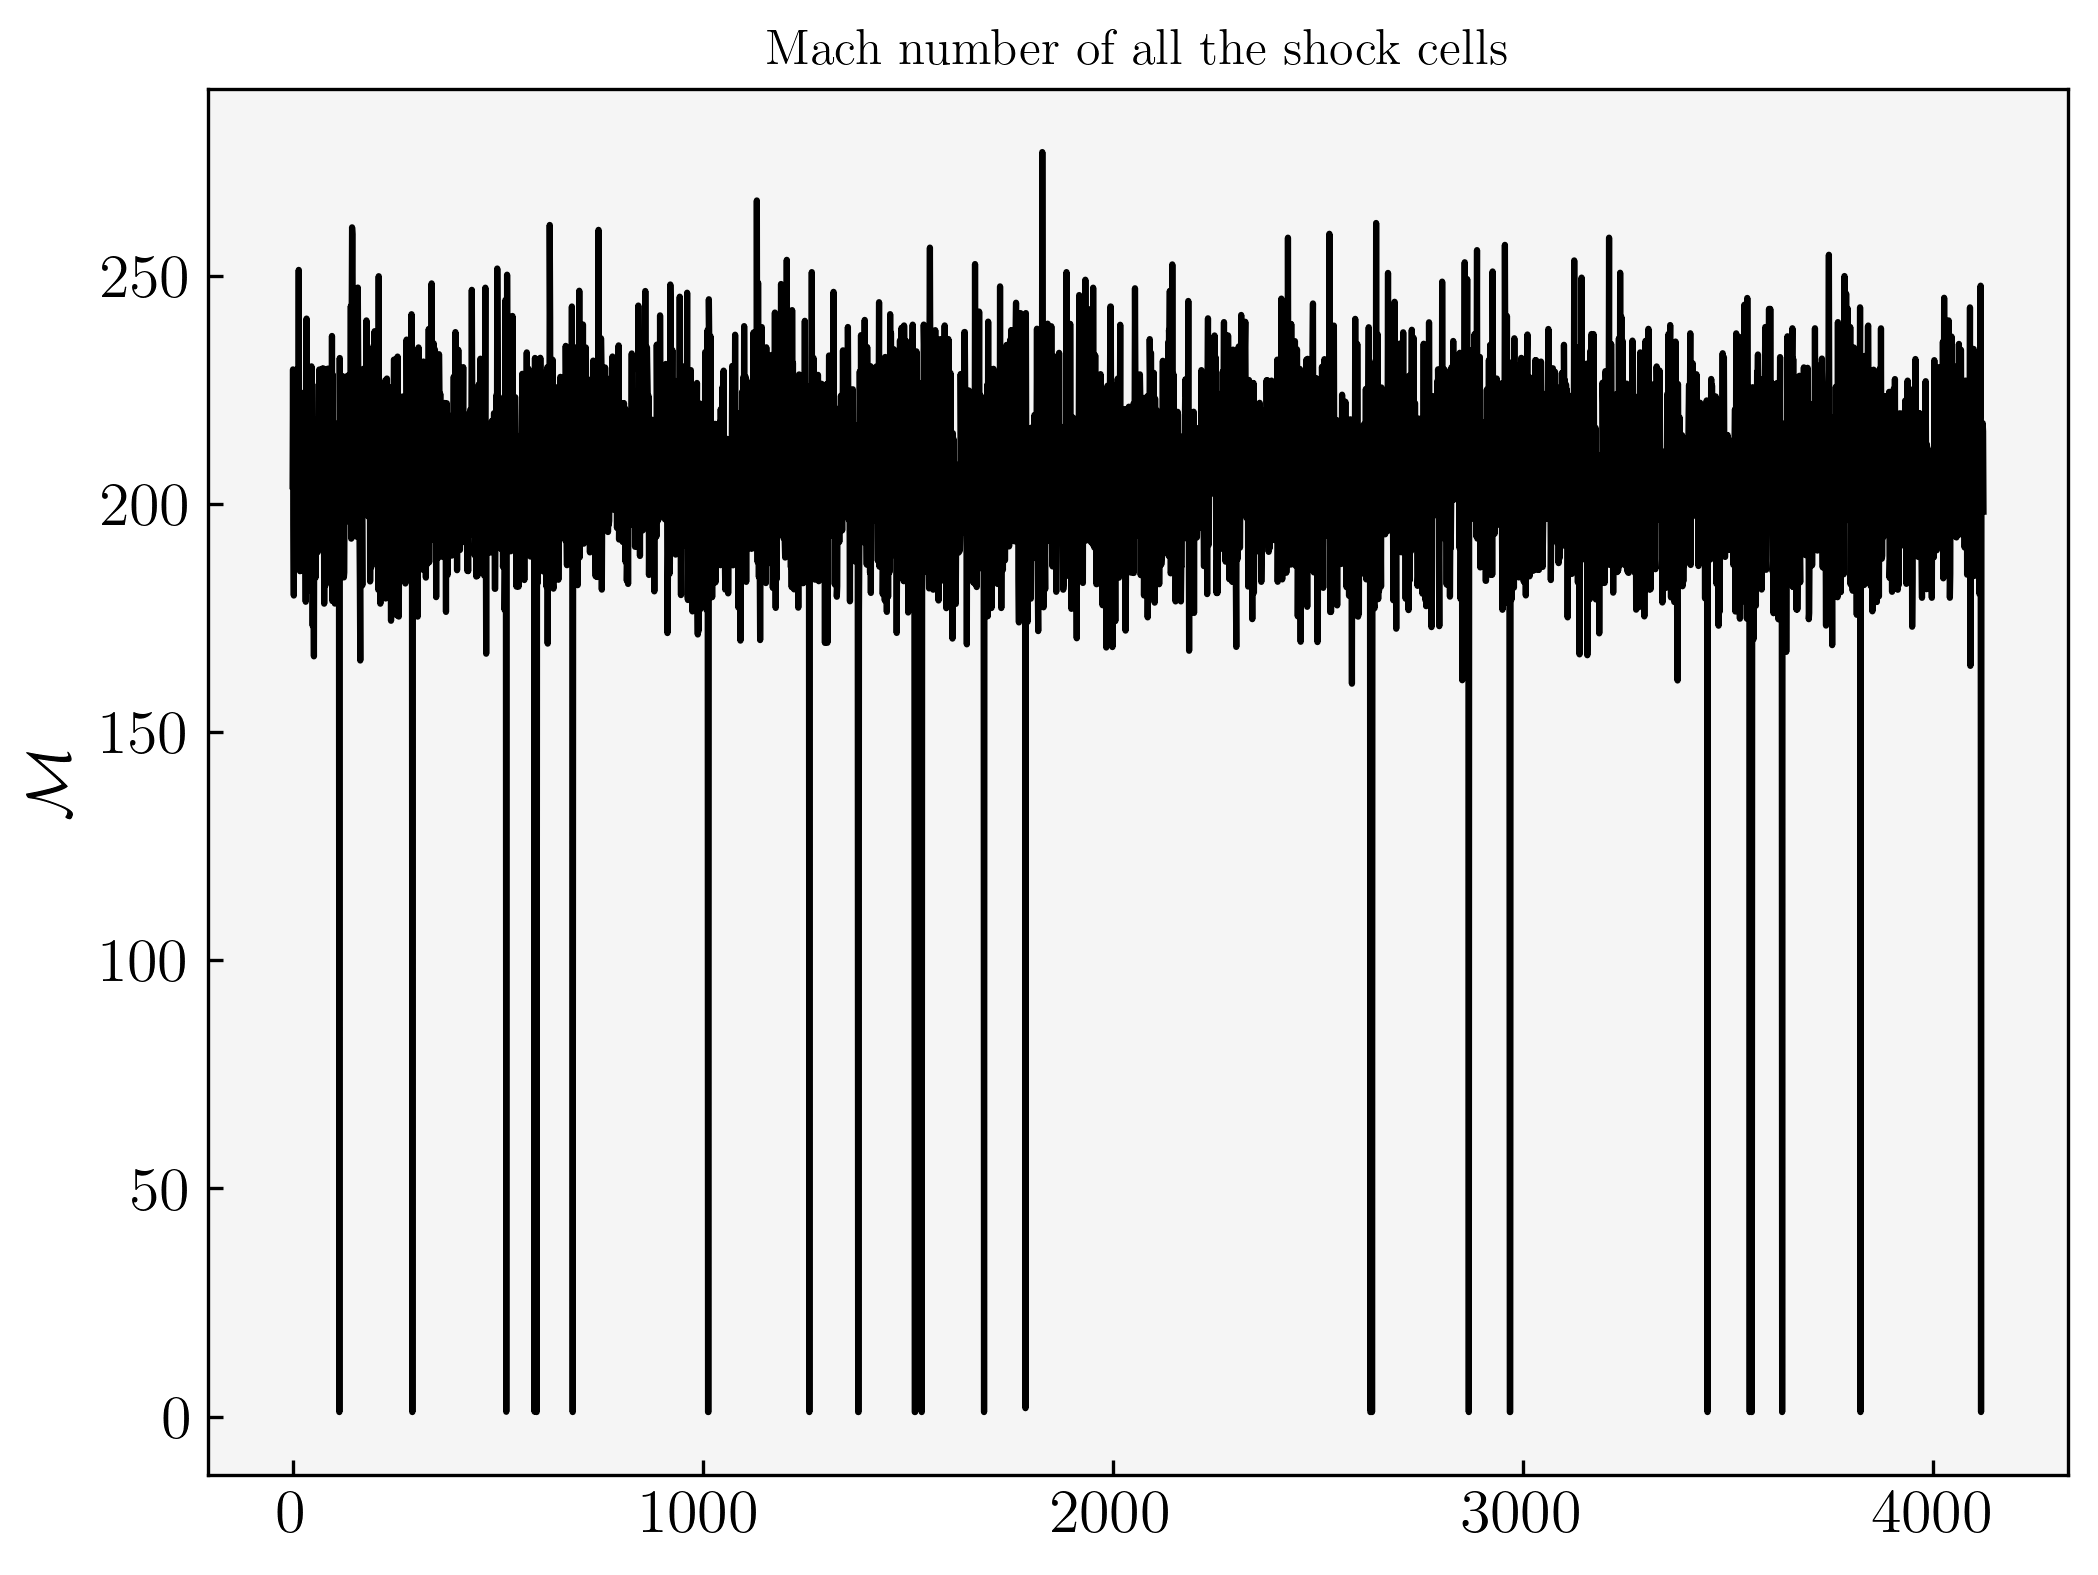

In [ ]:
plt.plot(surface_mach, c = 'k')
# plt.scatter(outlier, surface_mach[np.logical_and(surface_z<z_chosen+step, surface_z>z_chosen-step)][outlier], c = 'r')
plt.ylabel(r'$\mathcal{M}$', fontsize = 15)
plt.title('Mach number of all the shock cells')
if save == True:
  plt.savefig(f'Figs/6mach.png')
plt.show()

In [ ]:
# Cross section
slice_zone = np.logical_and(z_zone<z_chosen+0.02, z_zone>z_chosen-0.02)
zone_cross_x = x_zone[slice_zone]
zone_cross_y = y_zone[slice_zone]

slice_surface = np.logical_and(surface_z<z_chosen+0.02, surface_z>z_chosen-0.02)
surface_cross_x = surface_x[slice_surface]
surface_cross_y = surface_y[slice_surface]

cross_shockdirx = dir_x[slice_surface]
cross_shockdiry = dir_y[slice_surface]

slice_post = np.logical_and(post_z<z_chosen+0.02, post_z>z_chosen-0.02)
zone_post_x = post_x[np.logical_and(slice_surface, slice_post)] # post_x[slice_surface] 
zone_post_y = post_y[np.logical_and(slice_surface, slice_post)] # post_y[slice_surface]

slice_pre = np.logical_and(pre_z<z_chosen+0.02, pre_z>z_chosen-0.02)
zone_pre_x = pre_x[np.logical_and(slice_surface, slice_pre)] # pre_x[slice_surface]
zone_pre_y = pre_y[np.logical_and(slice_surface, slice_pre)] # pre_y[slice_surface]


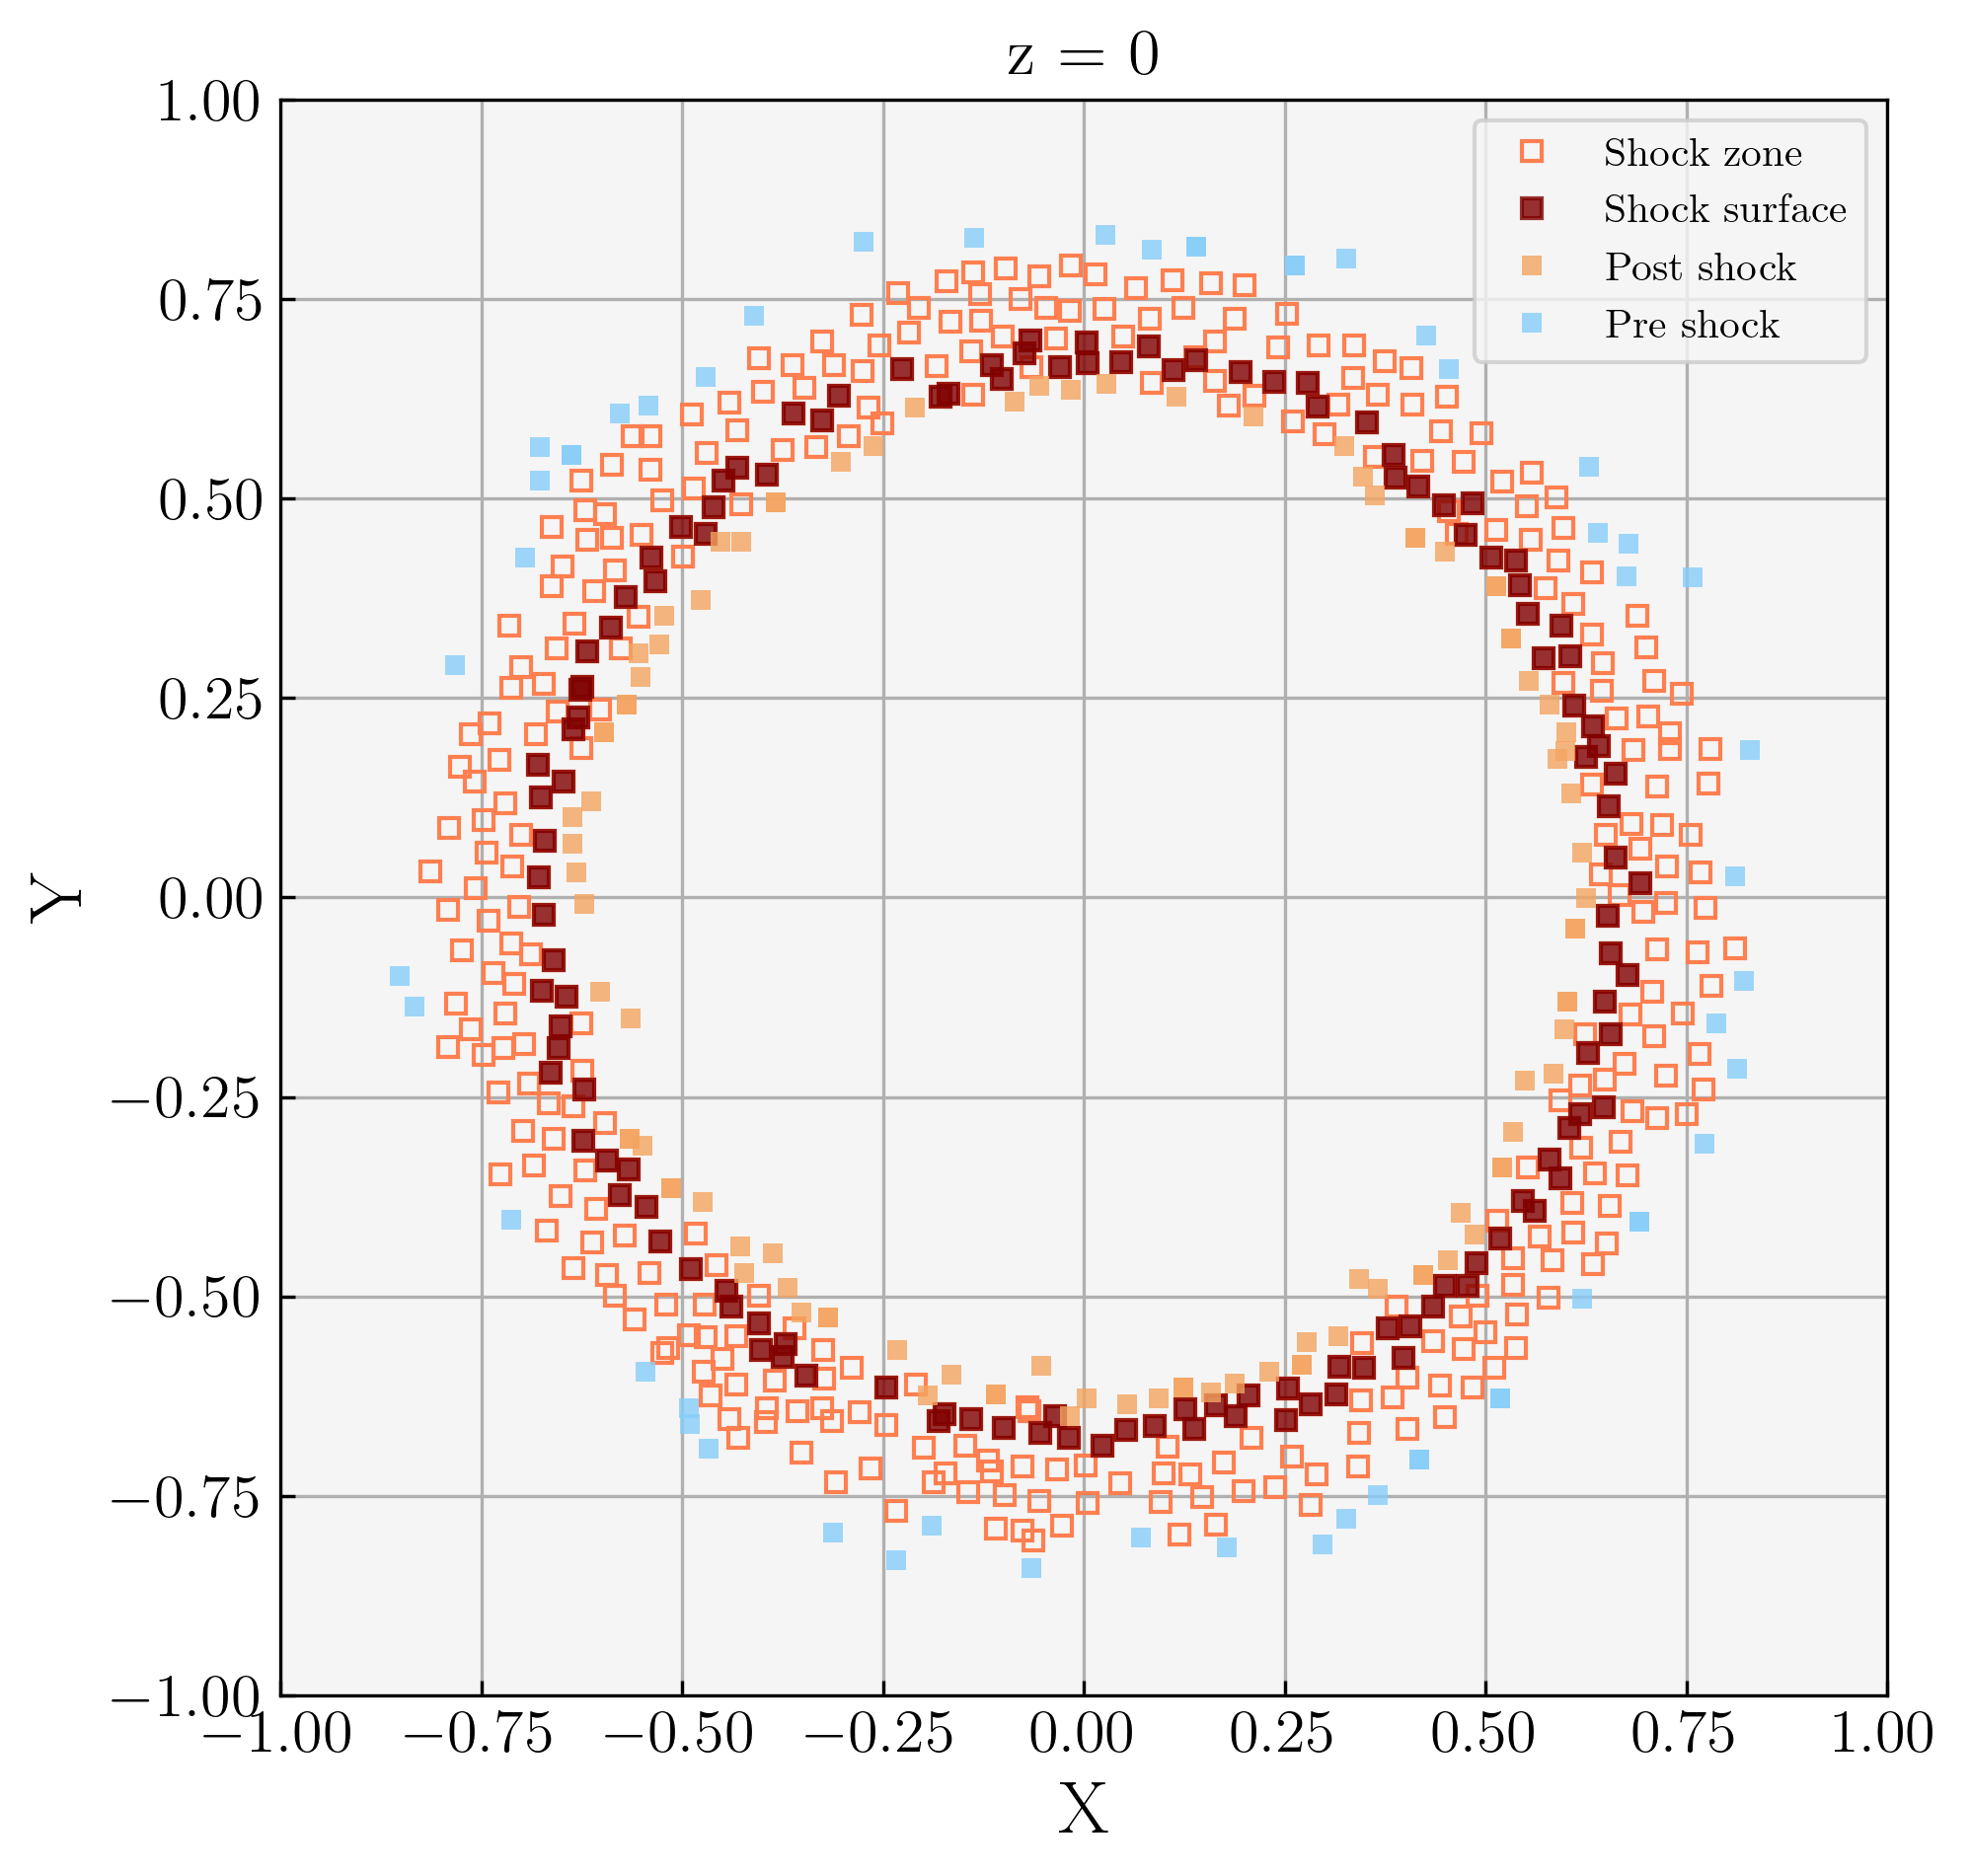

In [ ]:
# Maybe for every cell of the shock surface you don't see pre/post because they are not on the same layers
fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='coral', label = 'Shock zone')
ax.plot(surface_cross_x, surface_cross_y, 'ks', markerfacecolor='maroon', ms = 5, markeredgecolor='maroon',  alpha = 0.8, label = 'Shock surface')

#ax.quiver(surface_cross_x, surface_cross_y, cross_shockdirx, cross_shockdiry, color = 'k', angles='xy', scale_units='xy', scale = 2)
ax.plot(zone_post_x, zone_post_y, 'ks', markerfacecolor='sandybrown', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Post shock')
ax.plot(zone_pre_x, zone_pre_y, 'ks', markerfacecolor='lightskyblue', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Pre shock')

# ax.plot(surface_cross_x[outlier], surface_cross_y[outlier], 'ks', markerfacecolor='r', ms = 7, markeredgecolor='r',  label = 'outlier')
# ax.plot(post_x[slice_surface][outlier], post_y[slice_surface][outlier], 'ks', markerfacecolor='orange', ms = 7, markeredgecolor='orange',  label = 'outlier post')
# ax.plot(pre_x[slice_surface][outlier], pre_y[slice_surface][outlier], 'ks', markerfacecolor='b', ms = 7, markeredgecolor='b',  label = 'outlier pre')

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_xlabel('X', fontsize = 18)
ax.set_ylabel('Y', fontsize = 18)
ax.legend()
ax.set_title(f'z = {z_chosen}', fontsize = 16)
plt.ylim(-1,1)
plt.xlim(-1,1)
plt.grid()
if save == True:
    plt.savefig(f'Figs/5shocksurface_z{z_chosen}.png')
plt.show()

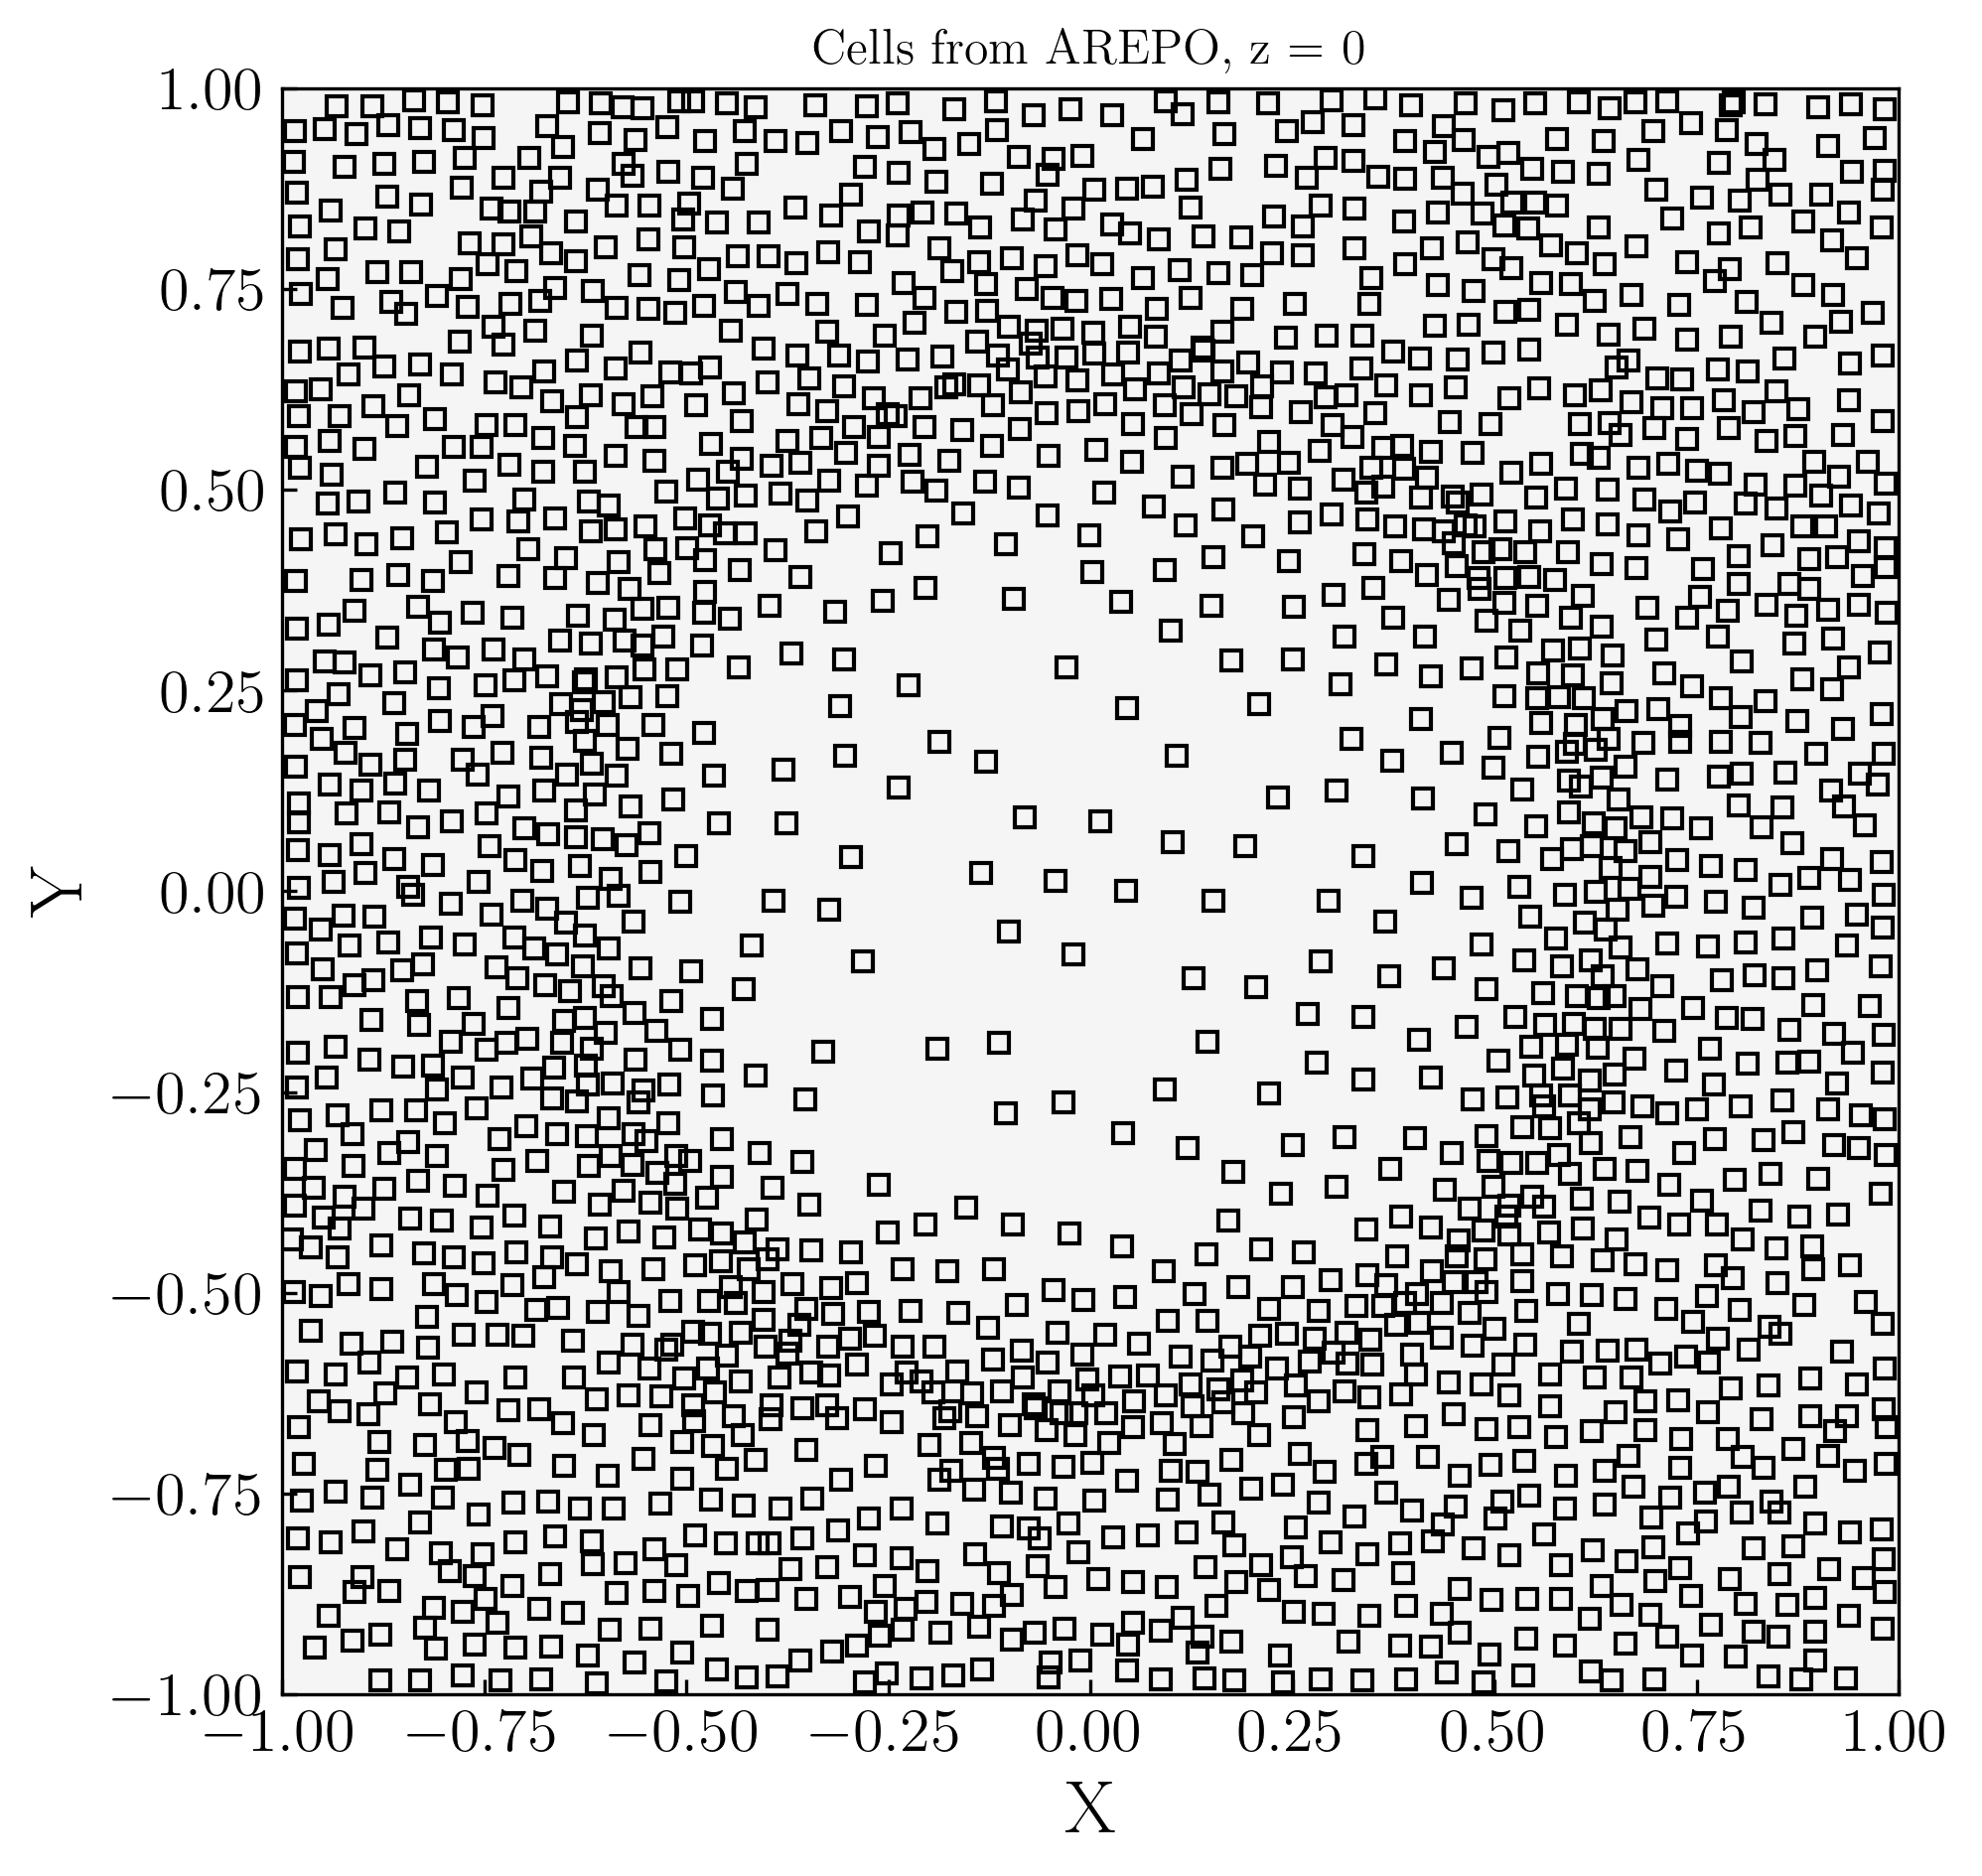

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (7,7))
ax.plot(X[np.logical_and(Z<z_chosen+0.02, Z>z_chosen-0.02)], Y[np.logical_and(Z<z_chosen+0.02, Z>z_chosen-0.02)], 'ks', markerfacecolor='none', ms = 5, markeredgecolor='k')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel('X', fontsize = 18)
ax.set_ylabel('Y', fontsize = 18)
plt.title(f'Cells from AREPO, z = {z_chosen}')
if save == True:
    plt.savefig('Figs/0cross_section.png')
plt.show()

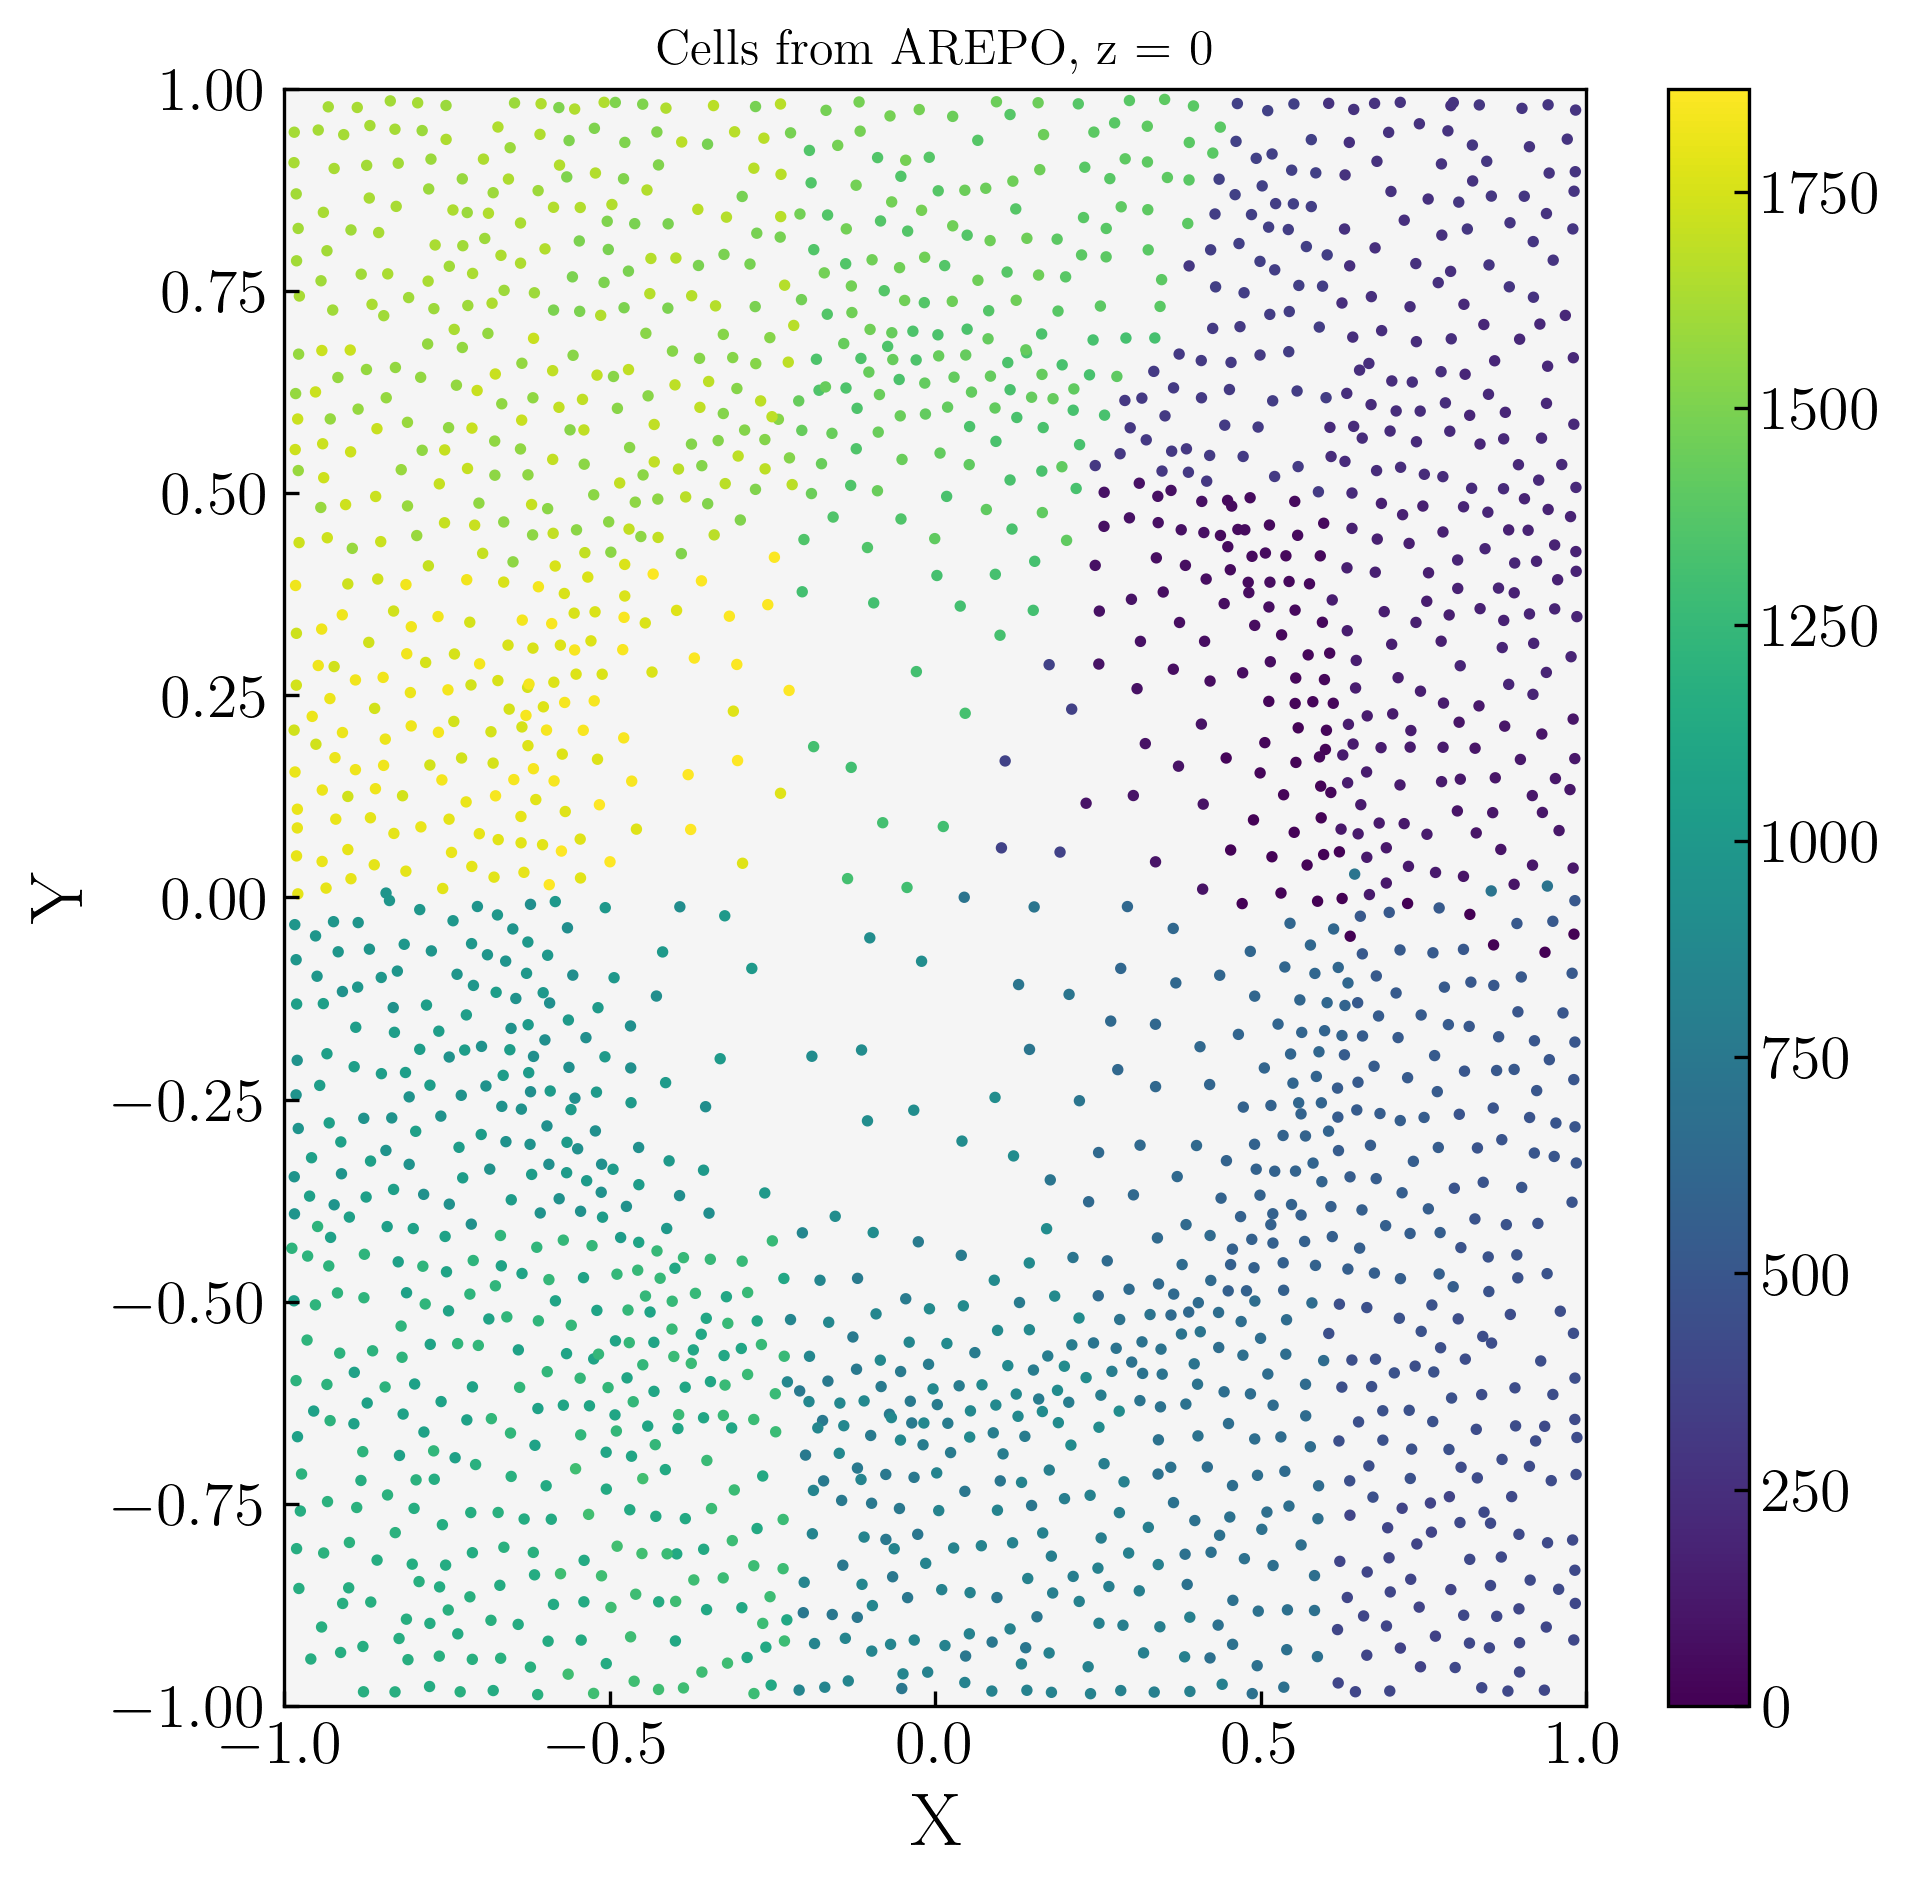

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (7,7))
img = ax.scatter(X[np.logical_and(Z<z_chosen+0.02, Z>z_chosen-0.02)], Y[np.logical_and(Z<z_chosen+0.02, Z>z_chosen-0.02)], c = np.arange(len(X[np.logical_and(Z<z_chosen+0.02, Z>z_chosen-0.02)])), s=3)
cbar = plt.colorbar(img)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel('X', fontsize = 18)
ax.set_ylabel('Y', fontsize = 18)
plt.title(f'Cells from AREPO, z = {z_chosen}')
if save == True:
    plt.savefig('Figs/0cross_section_positions.png')
plt.show()